#Importar base

In [584]:
# Importação dos pacotes

import pandas as pd
import numpy as np
import calendar
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.offline as offline
import plotly.graph_objs as go

In [585]:
df = pd.read_csv('Walmart.csv', header=0, parse_dates=True,squeeze=True) 
df.head()


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


#Modelagem da base - Separação da store 1 e vendas semanais

In [586]:
df = df.iloc[:,[0,1,2]]
df

,Store,Date,Weekly_Sales
0,1,05-02-2010,1643690.90
1,1,12-02-2010,1641957.44
2,1,19-02-2010,1611968.17
3,1,26-02-2010,1409727.59
4,1,05-03-2010,1554806.68
...,...,...,...
6430,45,28-09-2012,713173.95
6431,45,05-10-2012,733455.07
6432,45,12-10-2012,734464.36
6433,45,19-10-2012,718125.53


In [587]:
df = df[(df['Store'] == 1)]
df

,Store,Date,Weekly_Sales
0,1,05-02-2010,1643690.90
1,1,12-02-2010,1641957.44
2,1,19-02-2010,1611968.17
3,1,26-02-2010,1409727.59
4,1,05-03-2010,1554806.68
...,...,...,...
138,1,28-09-2012,1437059.26
139,1,05-10-2012,1670785.97
140,1,12-10-2012,1573072.81
141,1,19-10-2012,1508068.77


In [588]:
df=df[df['Store']==1][['Date','Weekly_Sales']]

df=df.set_index('Date')

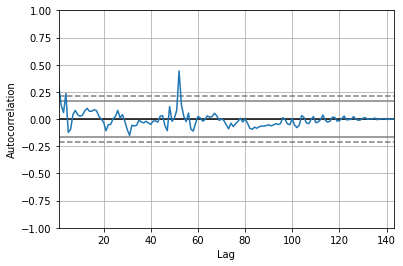

In [589]:
# elimina os warnings das bibliotecas

import warnings
warnings.filterwarnings("ignore")
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot
autocorrelation_plot(df)
pyplot.show()

In [590]:
import pandas.util.testing as tm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot

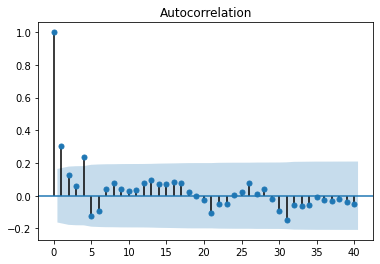

In [591]:
plot_acf(df, lags=40)
pyplot.show()

In [592]:
140

140

In [593]:
window = 20
dataSize = len(df)
x = []
y = []
for i in range(window, dataSize):
    x.append(df.iloc[i-window:i, 0])
    y.append(df.iloc[i, 0])
x, y = np.array(x), np.array(y)

In [594]:
print(x.shape)
print(y.shape)

(123, 20)
(123,)


In [595]:
import random
np.random.seed(0) #semente inicial (reprodução de resultados)

#Separação entre Treino e Teste   
#Normalização



In [596]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

#normalizar
from sklearn.preprocessing import StandardScaler

scaler_x = StandardScaler().fit(x_train)
x_train = scaler_x.transform(x_train)
x_test = scaler_x.transform(x_test)
scaler_y = StandardScaler().fit(y_train.reshape(-1,1))
y_train = scaler_y.transform(y_train.reshape(-1,1))
y_test = scaler_y.transform(y_test.reshape(-1,1))



#Modelo Random Forest

In [597]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 10, random_state=0)
regressor.fit(x_train, y_train);

In [598]:
y_pred = regressor.predict(x_test)
y_pred[0:5]

array([ 0.05104574,  0.08792201,  0.44042867,  0.07758856, -0.54569804])

In [599]:
y_prev = scaler_y.inverse_transform(y_pred.reshape(-1,1))
y_real = scaler_y.inverse_transform(y_test.reshape(-1,1))

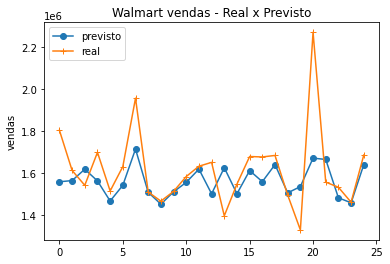

In [600]:
plt.plot(y_prev, label='previsto', marker='o')
plt.plot(y_real, label='real', marker='+')
plt.ylabel("vendas")
plt.title("Walmart vendas - Real x Previsto")
plt.legend()
plt.show()

In [601]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(y_prev,y_real))
print('RMSE: ', rmse)

RMSE:  164252.01236760808


In [602]:
mse = mean_squared_error(y_prev,y_real)
print('MSE: ',mse)

MSE:  26978723566.808884


In [603]:
mape = np.mean(np.abs((y_real - y_prev) / y_real)) * 100
print('MAPE: ',mape, '%')

MAPE:  6.099886427098071 %


In [604]:
from sklearn.metrics import r2_score
r2_score(y_prev,y_real)

-4.3235719598632825

In [605]:
rmspe = np.sqrt(np.mean(np.square(((y_real - y_prev) / y_real)), axis=0)) * 100
print('rmspe: ',rmspe, '%')

rmspe:  [8.77648461] %


In [606]:
#prevendo 12 passos a frente
timesteps_to_predict = 12
lag = df.iloc[dataSize-window:dataSize,0].values

predictions=[]
for i in range(timesteps_to_predict):
  lag = scaler_x.transform(lag.reshape(1,-1))#scaler_x
  prediction = regressor.predict(lag)
  prediction_to_add = scaler_y.inverse_transform(prediction.reshape(-1,1)) #scaler_y
  predictions.append(prediction_to_add)
  lag = scaler_x.inverse_transform(lag) #scaler_x

  lag = lag[0, 1:]  
  lag = np.append(lag, prediction_to_add)

predictions = np.array(predictions).reshape(-1,1)

In [607]:
predictions

array([[1573555.925],
       [1614770.266],
       [1511847.141],
       [1478858.318],
       [1523275.979],
       [1655909.028],
       [1543740.539],
       [1486388.748],
       [1499254.953],
       [1562426.095],
       [1602843.062],
       [1447950.144]])

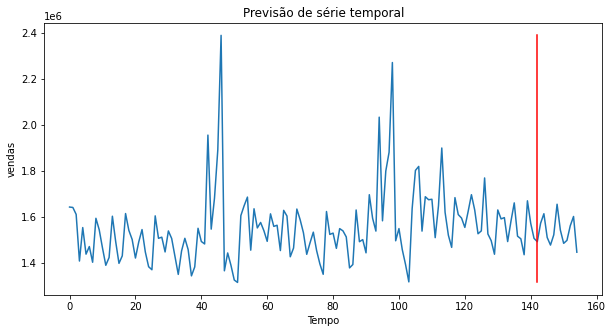

In [608]:
all_data = np.vstack((df, predictions.tolist()))
plt.figure(figsize=(10,5))
plt.plot(all_data)
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('vendas')

# marca o início das previsões
x = [len(df)-1, len(df)-1]
y = [df['Weekly_Sales'].min(), df['Weekly_Sales'].max()]
plt.plot(x, y, color='red')

#salva o gráfico
plt.show()

#Modelo Decision Tree

In [609]:
from sklearn.tree import DecisionTreeRegressor
regressor1 = DecisionTreeRegressor()
regressor1.fit(x_train, y_train);

In [610]:
y_pred1 = regressor1.predict(x_test)
y_pred1[0:5]

array([ 0.30397458,  0.9627918 ,  0.36632585,  0.00793686, -0.30289359])

In [611]:
y_prev1 = scaler_y.inverse_transform(y_pred1.reshape(-1,1))
y_real1 = scaler_y.inverse_transform(y_test.reshape(-1,1))

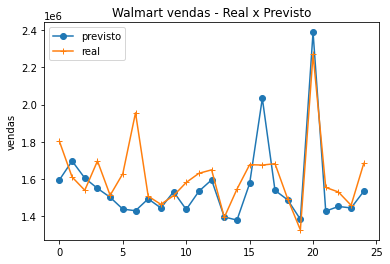

In [612]:
plt.plot(y_prev1, label='previsto', marker='o')
plt.plot(y_real1, label='real', marker='+')
plt.ylabel("vendas")
plt.title("Walmart vendas - Real x Previsto")
plt.legend()
plt.show()

In [613]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(y_prev1,y_real1))
print('RMSE: ', rmse)

RMSE:  163784.034443059


In [614]:
mse = mean_squared_error(y_prev1,y_real1)
print('MSE: ',mse)

MSE:  26825209938.445137


In [615]:
mape = np.mean(np.abs((y_real1 - y_prev1) / y_real1)) * 100
print('MAPE: ',mape, '%')

MAPE:  6.824501442820444 %


In [616]:
from sklearn.metrics import r2_score
r2_score(y_pred1,y_test)

0.4116421471098267

In [617]:
rmspe = np.sqrt(np.mean(np.square(((y_real1 - y_prev1) / y_real1)), axis=0)) * 100
print('rmspe: ',rmspe, '%')

rmspe:  [9.25900233] %


In [618]:
#prevendo 12 passos a frente
timesteps_to_predict = 12
lag = df.iloc[dataSize-window:dataSize,0].values

predictions=[]
for i in range(timesteps_to_predict):
  lag = scaler_x.transform(lag.reshape(1,-1))
  prediction = regressor1.predict(lag)
  prediction_to_add = scaler_y.inverse_transform(prediction.reshape(-1,1))
  predictions.append(prediction_to_add)
  lag = scaler_x.inverse_transform(lag)

  lag = lag[0, 1:]  
  lag = np.append(lag, prediction_to_add)

predictions = np.array(predictions).reshape(-1,1)

In [619]:
predictions

array([[1437059.26],
       [1635078.41],
       [1494479.49],
       [1502562.78],
       [1371986.6 ],
       [1635078.41],
       [1525147.09],
       [1502562.78],
       [1453329.5 ],
       [1635078.41],
       [1769854.16],
       [1494479.49]])

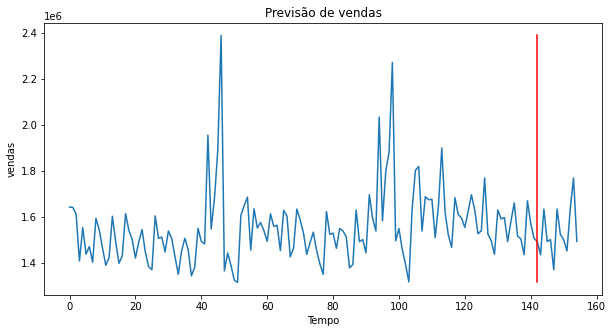

In [620]:
all_data = np.vstack((df, predictions))
plt.figure(figsize=(10,5))
plt.plot(all_data)
plt.title('Previsão de vendas')
plt.xlabel('Tempo')
plt.ylabel('vendas')

# marca o início das previsões
x = [len(df)-1, len(df)-1]
y = [df['Weekly_Sales'].min(), df['Weekly_Sales'].max()]
plt.plot(x, y, color='red')


In [621]:
x_train.shape

(98, 20)

#RNN

In [622]:
# Rede Neural"""
from keras import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

RN = Sequential()
RN.add(Dense(32,input_shape = x_train.shape[1:], activation = 'tanh'))
RN.add(Dense(16))
RN.add(Dense(1))
RN.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 32)                672       
                                                                 
 dense_36 (Dense)            (None, 16)                528       
                                                                 
 dense_37 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,217
Trainable params: 1,217
Non-trainable params: 0
_________________________________________________________________


In [623]:
x_train[:2]

array([[ 2.29674052,  0.51369632, -0.22738207, -0.5375396 ,  0.72561031,
         0.29472461,  0.21938529,  0.04174519,  0.48349957,  1.04743589,
         0.35976313, -0.20387983, -0.09101999,  1.64762866, -0.26324406,
        -0.39280945, -0.81953541,  0.3374482 ,  0.1458221 ,  0.1798099 ],
       [ 0.38299976, -0.40000928, -0.9115474 , -0.75967952,  0.31885598,
        -0.11948868, -0.3257401 , -0.81066212, -0.37169666,  0.02360006,
        -0.6555461 , -1.01624903, -1.11898696,  0.39682909, -0.37198335,
        -0.30163954, -0.74589148, -0.19793885, -0.3591051 , -0.78781183]])

In [624]:
y_train[:2]

array([[-0.35777103],
       [-1.28317501]])

In [625]:
RN.compile(optimizer = 'sgd', loss = 'mean_squared_error', metrics = ['accuracy']) 
history = RN.fit(x_train ,y_train, epochs = 100, validation_split=0.2)# Gráfico do treinamento: custo do treino e validação


Epoch 1/100
3/3 [==============================] - 0s 63ms/step - loss: 1.7149 - accuracy: 0.0000e+00 - val_loss: 2.0722 - val_accuracy: 0.0000e+00
Epoch 2/100
3/3 [==============================] - 0s 13ms/step - loss: 1.4945 - accuracy: 0.0000e+00 - val_loss: 1.8117 - val_accuracy: 0.0000e+00
Epoch 3/100
3/3 [==============================] - 0s 12ms/step - loss: 1.3491 - accuracy: 0.0000e+00 - val_loss: 1.5985 - val_accuracy: 0.0000e+00
Epoch 4/100
3/3 [==============================] - 0s 13ms/step - loss: 1.2188 - accuracy: 0.0000e+00 - val_loss: 1.4413 - val_accuracy: 0.0000e+00
Epoch 5/100
3/3 [==============================] - 0s 12ms/step - loss: 1.1441 - accuracy: 0.0000e+00 - val_loss: 1.3618 - val_accuracy: 0.0000e+00
Epoch 6/100
3/3 [==============================] - 0s 12ms/step - loss: 1.0819 - accuracy: 0.0000e+00 - val_loss: 1.2770 - val_accuracy: 0.0000e+00
Epoch 7/100
3/3 [==============================] - 0s 13ms/step - loss: 1.0223 - accuracy: 0.0000e+00 - val_loss

In [626]:
y_pred3 = RN.predict(x_test)
y_pred3


array([[-1.2918426 ],
       [ 0.30996114],
       [ 0.28824067],
       [ 0.87767184],
       [-1.0794145 ],
       [-0.85908973],
       [-0.66360337],
       [-0.387044  ],
       [-0.44624075],
       [-0.31263256],
       [-0.13948923],
       [ 0.31488383],
       [-0.8282534 ],
       [-0.5935308 ],
       [ 0.14114507],
       [ 0.38548172],
       [ 1.5219547 ],
       [ 0.8396626 ],
       [-0.38142174],
       [ 0.16371346],
       [ 3.526104  ],
       [ 0.23928556],
       [-1.4716467 ],
       [-0.8538459 ],
       [-0.34494546]], dtype=float32)

In [627]:
y_prev3 = scaler_y.inverse_transform(y_pred3.reshape(-1,1))
y_real = scaler_y.inverse_transform(y_test.reshape(-1,1))

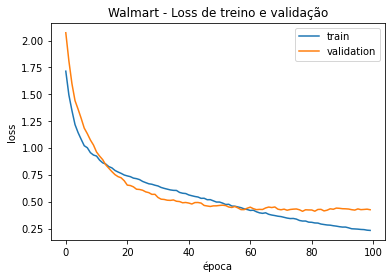

In [628]:
# Gráfico do treinamento: custo do treino e validação
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Walmart - Loss de treino e validação')
plt.ylabel('loss')
plt.xlabel('época')
plt.legend();

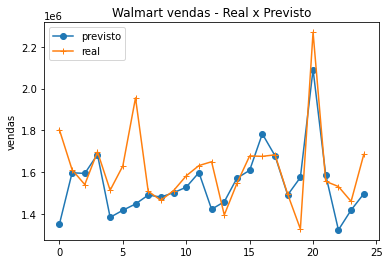

In [629]:
plt.plot(y_prev3, label='previsto', marker='o')
plt.plot(y_real, label='real', marker='+')
plt.ylabel("vendas")
plt.title("Walmart vendas - Real x Previsto")
plt.legend()
plt.show()

In [630]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(y_prev3,y_real))
print('RMSE: ', rmse)

RMSE:  176657.5269359608


In [631]:
mse = mean_squared_error(y_prev3,y_real)
print('MSE: ',mse)

MSE:  31207881823.129723


In [632]:
mape = np.mean(np.abs((y_real - y_prev3) / y_real)) * 100
print('MAPE: ',mape, '%')

MAPE:  6.932967876612207 %


In [633]:
from sklearn.metrics import r2_score
r2_score(y_pred3,y_test)

-0.2990645976255426

In [634]:
rmspe = np.sqrt(np.mean(np.square(((y_real - y_prev3) / y_real)), axis=0)) * 100
print('rmspe: ',rmspe, '%')

rmspe:  [10.16531628] %


In [635]:
timesteps_to_predict = 12
lag = df.iloc[dataSize-window:dataSize,0].values

predictions=[]
for i in range(timesteps_to_predict):
  lag = scaler_x.transform(lag.reshape(1,-1))
  prediction = RN.predict(lag)
  prediction_to_add = scaler_y.inverse_transform(prediction.reshape(-1,1))
  predictions.append(prediction_to_add)
  lag = scaler_x.inverse_transform(lag)

  lag = lag[0, 1:]  
  lag = np.append(lag, prediction_to_add)

predictions = np.array(predictions).reshape(-1,1)


In [636]:
predictions

array([[1565794.2],
       [1654679.1],
       [1479533.2],
       [1483798.1],
       [1541326. ],
       [1644910.2],
       [1507736.8],
       [1457653.1],
       [1512246.5],
       [1597465. ],
       [1533109.8],
       [1443623.8]], dtype=float32)

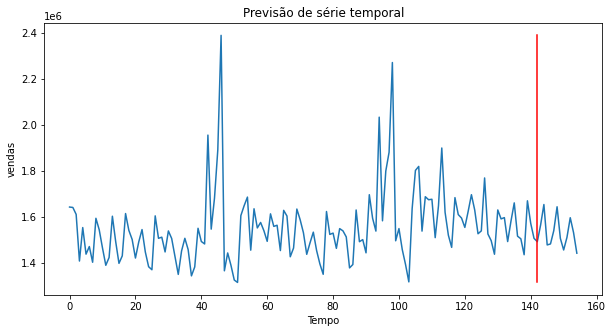

In [637]:
all_data = np.vstack((df, predictions.tolist()))
plt.figure(figsize=(10,5))
plt.plot(all_data)
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('vendas')

# marca o início das previsões
x = [len(df)-1, len(df)-1]
y = [df['Weekly_Sales'].min(), df['Weekly_Sales'].max()]
plt.plot(x, y, color='red')

#salva o gráfico
plt.show()


# LSTM

In [638]:
# LSTM  with window regression framing
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [639]:
x_train.shape, x_test.shape

((98, 20), (25, 20))

In [640]:
y_train.shape, y_test.shape

((98, 1), (25, 1))

In [641]:
# reshape input to be [samples, time steps, features]
x_train_reshaped = numpy.reshape(x_train, (x_train.shape[0],-1, x_train.shape[1]))
x_test_reshaped = numpy.reshape(x_test, (x_test.shape[0], -1, x_test.shape[1]))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(32,input_shape=(x_train_reshaped.shape[1], x_train_reshaped.shape[2]) ,return_sequences=True))
# model.add(Dropout(0.3))
model.add(BatchNormalization())

# batchnorm
model.add(LSTM(8))
model.add(Dropout(0.3))
# model.add(BatchNormalization())

# novas dense
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', metrics=['mse'], optimizer='adam')


monitor='val_loss'
lr_reduce = ReduceLROnPlateau(monitor=monitor, factor=0.6, min_delta=0.0001, patience=4, verbose=1)
early = EarlyStopping(monitor=monitor,mode="min",patience=18)
callbacks_list = [early, lr_reduce]

model.fit(x_train_reshaped, y_train, epochs = 100, batch_size = 1, callbacks=callbacks_list,validation_data=(x_test_reshaped, y_test))



Epoch 1/100
98/98 [==============================] - 3s 10ms/step - loss: 1.0017 - mse: 1.0017 - val_loss: 1.6542 - val_mse: 1.6542 - lr: 0.0010
Epoch 2/100
98/98 [==============================] - 0s 3ms/step - loss: 1.0040 - mse: 1.0040 - val_loss: 1.6456 - val_mse: 1.6456 - lr: 0.0010
Epoch 3/100
98/98 [==============================] - 0s 3ms/step - loss: 1.0022 - mse: 1.0022 - val_loss: 1.6410 - val_mse: 1.6410 - lr: 0.0010
Epoch 4/100
98/98 [==============================] - 0s 3ms/step - loss: 1.0038 - mse: 1.0038 - val_loss: 1.6539 - val_mse: 1.6539 - lr: 0.0010
Epoch 5/100
98/98 [==============================] - 0s 3ms/step - loss: 1.0044 - mse: 1.0044 - val_loss: 1.6419 - val_mse: 1.6419 - lr: 0.0010
Epoch 6/100
98/98 [==============================] - 0s 3ms/step - loss: 1.0035 - mse: 1.0035 - val_loss: 1.6442 - val_mse: 1.6442 - lr: 0.0010
Epoch 7/100
92/98 [===========================>..] - ETA: 0s - loss: 1.0436 - mse: 1.0436
Epoch 7: ReduceLROnPlateau reducing learning 

In [642]:
# make predictions
trainPredict = model.predict(x_train_reshaped)
testPredict = model.predict(x_test_reshaped)
# invert predictions
trainPredict = scaler_y.inverse_transform(trainPredict.reshape(-1,1))
y_train_desnorm = scaler_y.inverse_transform(y_train)
testPredict = scaler_y.inverse_transform(testPredict.reshape(-1,1))
y_test_desnorm = scaler_y.inverse_transform(y_test)

In [643]:
trainPredict[:2]

array([[1528250.6],
       [1567423.1]], dtype=float32)

In [644]:
y_train_desnorm[:2]

array([[1494122.38],
       [1351791.03]])

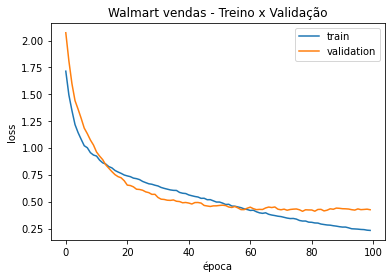

In [645]:
# Gráfico do treinamento: treino e validação
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Walmart vendas - Treino x Validação')
plt.ylabel('loss')
plt.xlabel('época')
plt.legend();

In [646]:
y_pred4 = model.predict(x_test_reshaped)
y_pred4

array([[-0.05406592],
       [-0.5138978 ],
       [-0.1436863 ],
       [-0.1106038 ],
       [-0.29746386],
       [ 0.35015893],
       [-0.05993978],
       [-0.02149298],
       [-0.14556551],
       [ 0.03659322],
       [-0.07189045],
       [-0.11011126],
       [ 0.5259282 ],
       [-0.12706499],
       [-0.04158277],
       [-0.13268928],
       [-0.34965342],
       [ 0.02324989],
       [ 0.07331   ],
       [-0.20261748],
       [ 0.04328172],
       [ 0.4602507 ],
       [-0.15672992],
       [-0.10771385],
       [-0.17081422]], dtype=float32)

In [647]:
y_prev4 = scaler_y.inverse_transform(y_pred4.reshape(-1,1))
y_real = scaler_y.inverse_transform(y_test.reshape(-1,1))

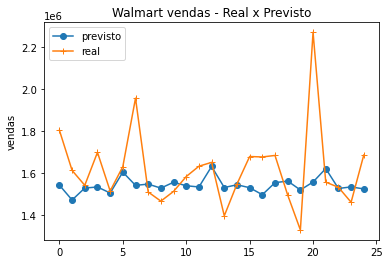

In [648]:
plt.plot(y_prev4, label='previsto', marker='o')
plt.plot(y_real, label='real', marker='+')
plt.ylabel("vendas")
plt.title("Walmart vendas - Real x Previsto")
plt.legend()
plt.show()

In [649]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(y_prev4,y_real))
print('RMSE: ', rmse)

RMSE:  198503.65678182148


In [650]:
mse = mean_squared_error(y_prev4,y_real)
print('MSE: ',mse)

MSE:  39403701755.75518


In [651]:
mape = np.mean(np.abs((y_real - y_prev4) / y_real)) * 100
print('MAPE: ',mape, '%')

MAPE:  7.346901703817006 %


In [652]:
from sklearn.metrics import r2_score
r2_score(y_pred4,y_test)

-32.391087545887245

In [653]:
rmspe = np.sqrt(np.mean(np.square(((y_real - y_prev4) / y_real)), axis=0)) * 100
print('rmspe: ',rmspe, '%')

rmspe:  [10.22618955] %


In [654]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train_desnorm, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test_desnorm, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 160881.45 RMSE
Test Score: 198503.66 RMSE


In [655]:
#prevendo 12 passos a frente
timesteps_to_predict = 12
lag = df.iloc[dataSize-window:dataSize,0].values

predictions=[]
for i in range(timesteps_to_predict):
  lag = scaler_x.transform(lag.reshape(1,-1))
  lag = numpy.reshape(lag, (lag.shape[0], -1, lag.shape[1]))
  prediction = model.predict(lag)
  prediction_to_add = scaler_y.inverse_transform(prediction.reshape(-1,1))
  predictions.append(prediction_to_add)
  lag = scaler_x.inverse_transform(lag.reshape(-1,lag.shape[2]))

  lag = lag[0, 1:]  
  lag = np.append(lag, prediction_to_add)

predictions = np.array(predictions).reshape(-1,1)


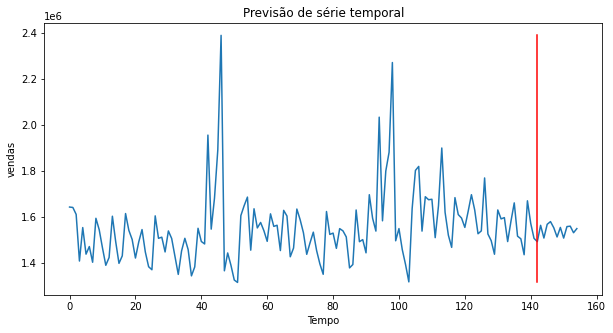

In [656]:
all_data = np.vstack((df, predictions.tolist()))
plt.figure(figsize=(10,5))
plt.plot(all_data)
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('vendas')

# marca o início das previsões
x = [len(df)-1, len(df)-1]
y = [df['Weekly_Sales'].min(), df['Weekly_Sales'].max()]
plt.plot(x, y, color='red')

#salva o gráfico
plt.show()
